In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import PIL
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [2]:
#!pip install torchsummary
from torchsummary import summary

In [8]:
img_size=256
n_channels=1

latent_size=100
batch_size=64
step_conv_channels=64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

beta1 = 0.5
beta2 = 0.999

lr=0.0002

num_workers=4

DATA_PATH = '...'
EPOCH_START=0
UPLOADED=False
LOAD_FILENAME_PATH_GENERATOR=('weights/generator_epoch_70.pth')

In [4]:
print(device)

cpu


In [5]:
class Split(object):
    def __call__(self, image):
        return transforms.Grayscale(num_output_channels=n_channels)(image[1,:,:].view(n_channels,img_size,img_size))

dataset = ImageFolder(DATA_PATH, transform=transforms.Compose([
        transforms.Resize(img_size,interpolation=transforms.InterpolationMode.BICUBIC),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.Resize(upsample_transform, interpolation=transforms.InterpolationMode.BICUBIC),
        #transforms.RandomCrop((IMG_WIDTH,IMG_HEIGHT)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
        Split()
        ]))
dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=num_workers)

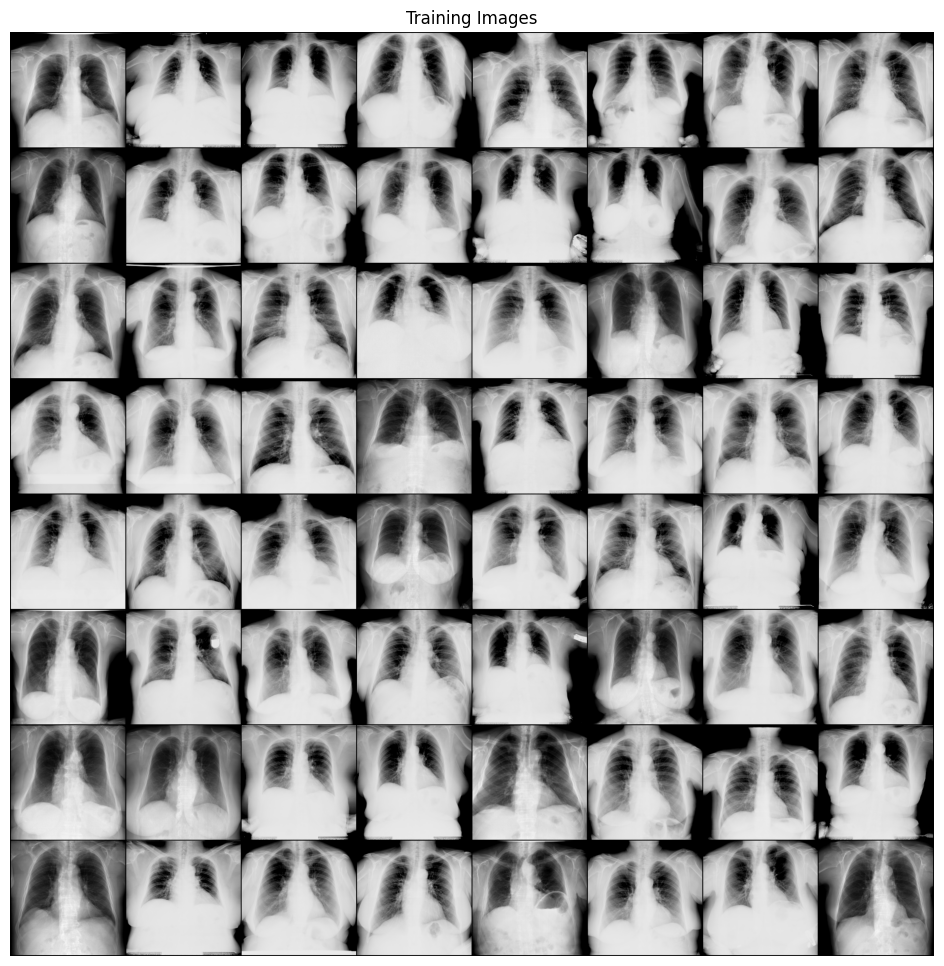

In [6]:
batch, _ = next(iter(dataloader))

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(batch.to(device), padding=2, normalize=True).cpu() ,(1,2,0)))

In [5]:
loss_g_per_batch = []
loss_d_per_batch = []
loss_g = []
loss_d = []
real_score_per_batch = []
fake_score_per_batch = []
real_score = []
fake_score = []
loss_g_per_batch = np.genfromtxt('logs/loss_g_per_batch.txt')
loss_d_per_batch = np.genfromtxt('logs/loss_d_per_batch.txt')
loss_g = np.genfromtxt('logs/losses_g.txt')
loss_d = np.genfromtxt('logs/losses_d.txt')
real_score_per_batch = np.genfromtxt('logs/real_score_per_batch.txt')
fake_score_per_batch = np.genfromtxt('logs/fake_score_per_batch.txt')
real_score = np.genfromtxt('logs/real_scores.txt')
fake_score = np.genfromtxt('logs/fake_scores.txt')

x_batch=np.arange(1,loss_g_per_batch.shape[0]+1)
x = np.arange(1,loss_g.shape[0]+1)

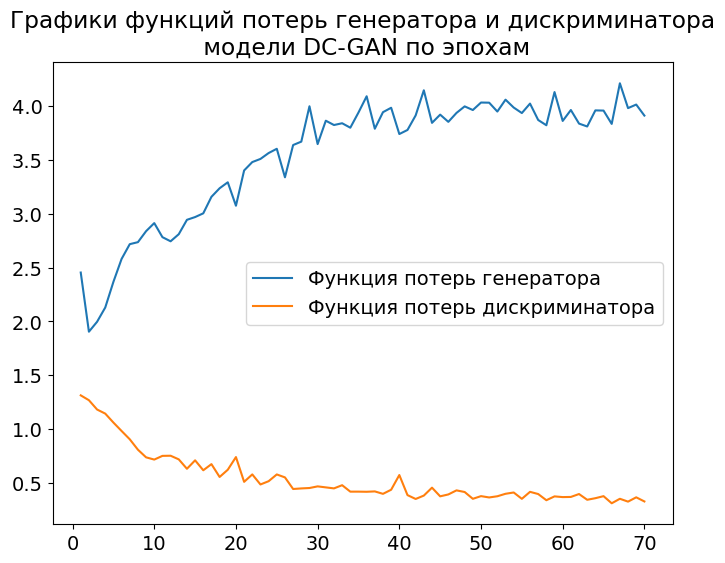

In [12]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})

plt.plot(x, loss_g, label='Функция потерь генератора')
plt.plot(x, loss_d, label='Функция потерь дискриминатора')
plt.title('Графики функций потерь генератора и дискриминатора\n модели DC-GAN по эпохам')
plt.legend()

plt.show()

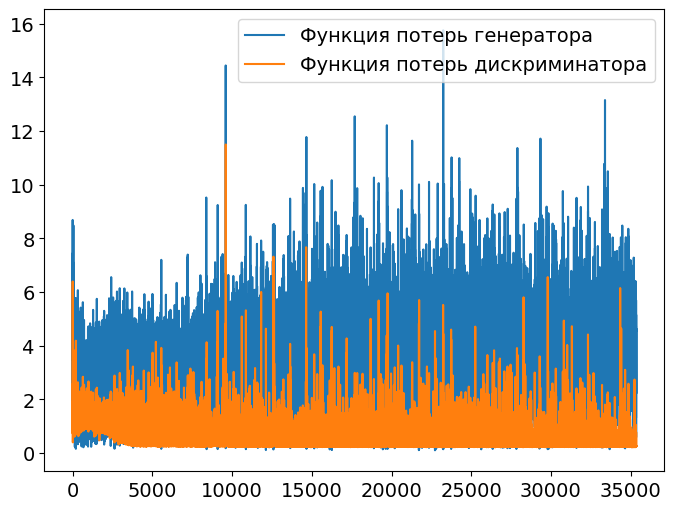

In [14]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})
plt.plot(x_batch, loss_g_per_batch, label='Функция потерь генератора')
plt.plot(x_batch, loss_d_per_batch, label='Функция потерь дискриминатора')
#plt.title('Графики функций потерь генератора и дискриминатора\n модели DC-GAN на каждой итерации обучения')
plt.legend()

plt.show()

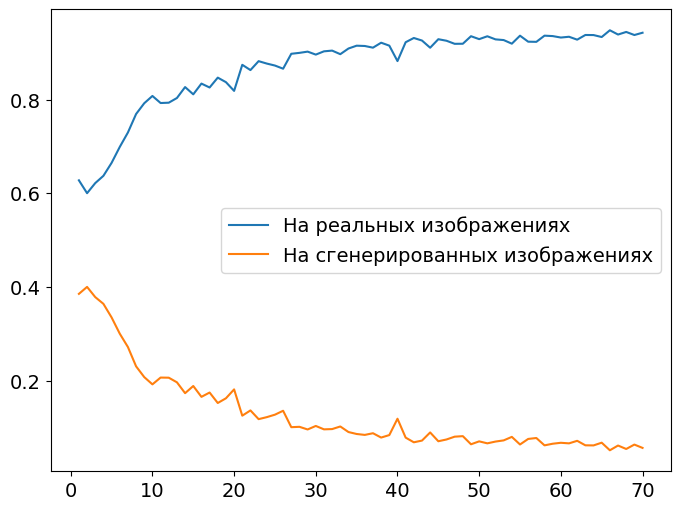

In [16]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})

plt.plot(x, real_score, label='На реальных изображениях')
plt.plot(x, fake_score, label='На сгенерированных изображениях')
plt.legend()

plt.show()

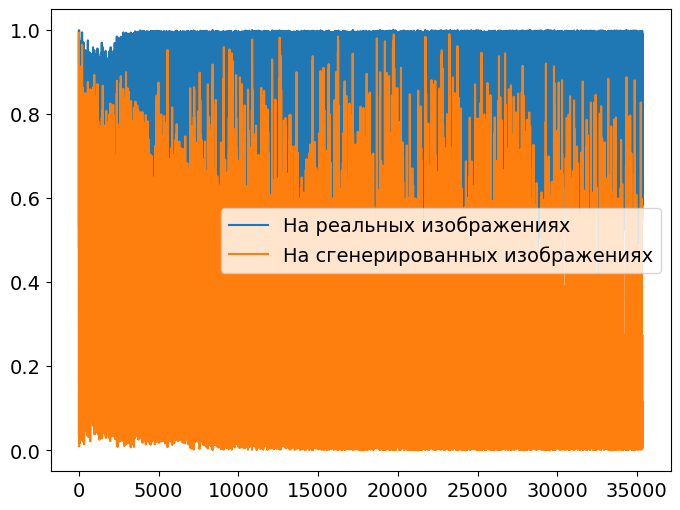

In [17]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})

plt.plot(x_batch, real_score_per_batch, label='На реальных изображениях')
plt.plot(x_batch, fake_score_per_batch, label='На сгенерированных изображениях')
plt.legend()

plt.show()

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.l1 = nn.Sequential(nn.Linear(latent_size, step_conv_channels*16 * 4 * 4))

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(step_conv_channels*16, step_conv_channels*16, 3, 1, 1),
            nn.BatchNorm2d(step_conv_channels*16),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # 8x8 
            nn.Conv2d(step_conv_channels*16, step_conv_channels*16, 3, stride=1, padding=1),
            nn.BatchNorm2d(step_conv_channels*16),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # 16x16
            nn.Conv2d(step_conv_channels*16, step_conv_channels*8, 3, stride=1, padding=1),
            nn.BatchNorm2d(step_conv_channels*8),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # 32x32
            nn.Conv2d(step_conv_channels*8, step_conv_channels*4, 3, stride=1, padding=1),
            nn.BatchNorm2d(step_conv_channels*4),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # 64x64
            nn.Conv2d(step_conv_channels*4, step_conv_channels*2, 3, stride=1, padding=1),
            nn.BatchNorm2d(step_conv_channels*2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # 128x128
            nn.Conv2d(step_conv_channels*2, step_conv_channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(step_conv_channels),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # 256x256
            nn.Conv2d(step_conv_channels, n_channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )
    
    def forward(self, z):
        z = z.view(z.shape[0],-1)
        out = self.l1(z)
        out = out.view(out.shape[0], step_conv_channels*16, 4, 4)
        img = self.conv_blocks(out)
        return img

In [6]:
g = Generator()
summary(g,(latent_size,1), device = 'cpu')

In [9]:
g.load_state_dict(torch.load(LOAD_FILENAME_PATH_GENERATOR, map_location = device))
g = g.to(device)
g.eval()

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=16384, bias=True)
  )
  (conv_blocks): Sequential(
    (0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode='nearest')
    (4): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Upsample(scale_factor=2.0, mode='nearest')
    (8): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Upsample(scale_factor=2.0, mode='nearest')
    (12): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [10]:
def show_generated(model, epochs = 1, n_images=32, latent_size=latent_size):
    with torch.no_grad():
        model.eval()
        fixed_latent = torch.randn(n_images, latent_size, device=device)
        fake_images = model(fixed_latent)
            
    plt.figure(figsize=(12, 12))
    plt.axis("off")
    plt.title("Generated Images %d epochs" %epochs)
    plt.imshow(np.transpose(make_grid(fake_images.to(device), padding=2, normalize=True).cpu() ,(1,2,0)))
    plt.show()

In [16]:
def leave_one_out_1nn(dataloader, model, n_images = 2000, latent_size=latent_size, batch_size = 50):
    with torch.no_grad():
        fixed_latent = torch.randn(batch_size, latent_size, device=device)
        fake_images = model(fixed_latent).to('cpu')
        for i in range(n_images//batch_size - 1):
            fixed_latent = torch.randn(batch_size, latent_size, device=device)
            fake_images = torch.cat((fake_images, model(fixed_latent).to('cpu')))
        
    real_images = next(iter(dataloader))[0]
    while real_images.shape[0]<n_images:
        real_images=torch.cat((real_images, next(iter(dataloader))[0]))
    real_images = real_images[:n_images]
    
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import LeaveOneOut
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    zeros = torch.zeros(n_images, 1)#, device=device)
    ones = torch.ones(n_images, 1)#, device=device)

    X = torch.cat((fake_images.to('cpu'), real_images.to('cpu'))).detach().numpy().reshape(-1, n_channels*img_size*img_size)
    y = torch.cat((zeros.to('cpu'), ones.to('cpu'))).detach().numpy()

    knc = KNeighborsClassifier(n_neighbors=1)
    loo = LeaveOneOut()

    accuracy_score_history = []
    predictions = []
    targets = []
    for train_index, test_index in tqdm(loo.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        knc.fit(X_train, np.ravel(y_train))
        pred = knc.predict(X_test)
        accuracy_score_history.append(accuracy_score(pred, y_test))
        predictions.append(pred)
        targets.append(y_test)
        
    print('Mean accuracy =', np.mean(accuracy_score_history))

    cm =  confusion_matrix([t.item() for t in targets],
                           [p.item() for p in predictions])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.grid(False)
    plt.show()

In [17]:
def scatter_distributions(dataloader, model, n_images=2000, latent_size=latent_size, batch_size = 50):
    from sklearn.manifold import TSNE
    with torch.no_grad():
        fixed_latent = torch.randn(batch_size, latent_size, device=device)
        fake_images = model(fixed_latent).to('cpu')
        for i in range(n_images//batch_size - 1):
            fixed_latent = torch.randn(batch_size, latent_size, device=device)
            fake_images = torch.cat((fake_images, model(fixed_latent).to('cpu')))
        
    real_images = next(iter(dataloader))[0]
    while real_images.shape[0]<n_images:
        real_images=torch.cat((real_images, next(iter(dataloader))[0]))
    real_images = real_images[:n_images]

    X = torch.cat((fake_images.to('cpu'), real_images.to('cpu'))).detach().numpy().reshape(-1, n_channels*img_size*img_size)

    X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(X)
    x1, x2 = zip(*X_embedded)
    plt.figure(figsize=(14,9))
    false = plt.scatter(x1[:2001],x2[:2001],c='salmon', s=30)
    true = plt.scatter(x1[2001:],x2[2001:],c='purple',s=30)
    plt.legend((false,true),('fake','real'))
    plt.show()

In [18]:
#show_generated(g)

In [19]:
#leave_one_out_1nn(dataloader, g)

In [20]:
#scatter_distributions(dataloader, g)

In [21]:
!pip install clean-fid

In [22]:
n_images=len(dataset)
os.mkdir('true')
os.mkdir('dcgan')
from cleanfid import fid

In [ ]:
i=0
real_images_path = '/kaggle/working/true'
for batch, _ in dataloader:
    for j in range(len(batch)):
        save_image((batch[j]+1)/2., real_images_path+'/%d.png' % (i*batch_size + j))
    i+=1

In [23]:
def calculate_fid(g, n_images = 1000, rearrange = False, batch_size=64):
    gen_images_path = '/kaggle/working/dcgan'
    if not os.path.isdir(gen_images_path):
        os.mkdir(gen_images_path)
    else:
        if len([name for name in os.listdir(gen_images_path)]) != n_images or rearrange:
            folderPath = gen_images_path
            for file in os.listdir(folderPath):
                fullFilePath = folderPath + "/" + file
                os.remove(fullFilePath)
                
    if len([name for name in os.listdir(gen_images_path)]) != n_images or rearrange:    
        g.eval()
        with torch.no_grad():
            cnt = n_images//batch_size
            for i in tqdm(range(cnt)):
                z = np.array([np.random.normal(0, 1, latent_size) for k in range(batch_size)])
                output = g(torch.FloatTensor(z).to(device))
                for j in range(batch_size):
                    save_image((output[j]+1)/2., gen_images_path+'/%d.png' % (i * batch_size + j))
            if n_images - cnt * batch_size != 0:
                z = np.array([np.random.normal(0, 1, latent_size) for i in range(n_images - cnt * batch_size)])
                output = g(torch.FloatTensor(z).to(device))
                for j in range(n_images - cnt * batch_size):
                    save_image((output[j]+1)/2., gen_images_path + '/%d.png' % (cnt * batch_size + j))
    #if on cpu num_workers should be >0
    score = fid.compute_fid(real_images_path, gen_images_path, mode = 'clean', num_workers = 4, device = device)
    return score

In [15]:
def load_model(model, epoch):
    state_dict = torch.load('weights/generator_epoch_%d.pth' %epoch, map_location=torch.device(device))        
    model.load_state_dict(state_dict)

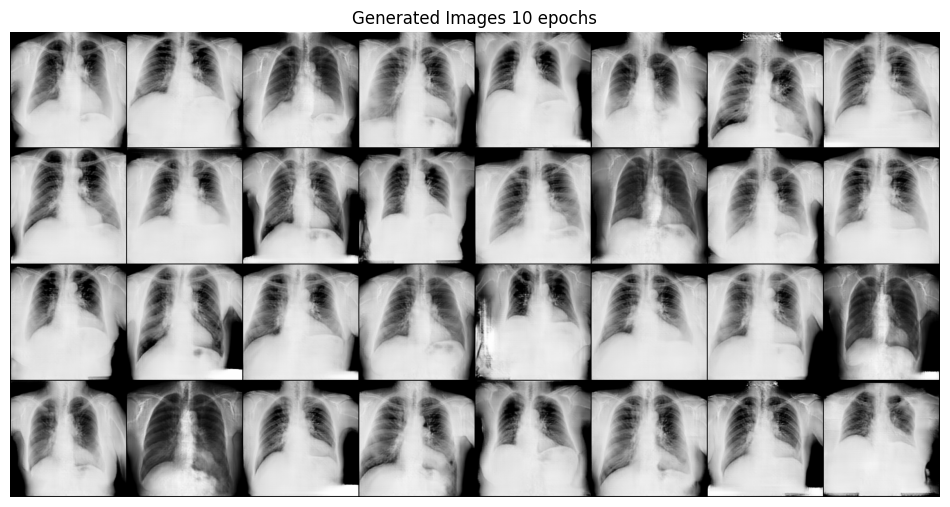

In [26]:
load_model(g, epoch = 10)
show_generated(g, epochs = 10)

In [27]:
fid_10 = calculate_fid(g, n_images = n_images, rearrange = True, batch_size = 64)
print('FID 10 epochs score: ', fid_10)

100%|██████████| 504/504 [11:38<00:00,  1.39s/it]


compute FID between two folders
Found 32263 images in the folder /kaggle/working/true


FID true : 100%|██████████| 1009/1009 [01:59<00:00,  8.43it/s]


Found 32263 images in the folder /kaggle/working/dcgan


FID dcgan : 100%|██████████| 1009/1009 [02:03<00:00,  8.18it/s]


FID 10 epochs score:  127.75115785023527


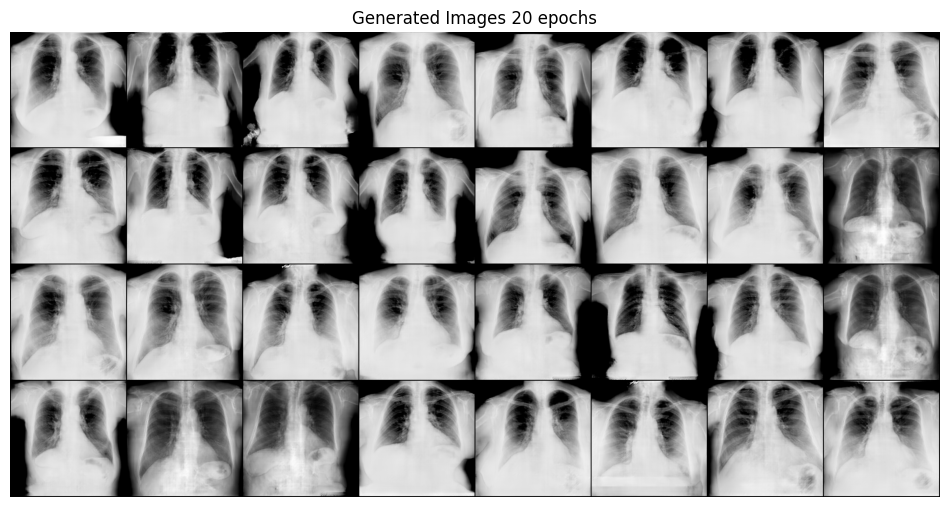

In [28]:
load_model(g, epoch = 20)
show_generated(g, epochs = 20)

In [29]:
fid_20 = calculate_fid(g, n_images = n_images, rearrange = True, batch_size = 64)
print('FID 10 epochs score: ', fid_20)

100%|██████████| 504/504 [11:18<00:00,  1.35s/it]


compute FID between two folders
Found 32263 images in the folder /kaggle/working/true


FID true : 100%|██████████| 1009/1009 [02:00<00:00,  8.37it/s]


Found 32263 images in the folder /kaggle/working/dcgan


FID dcgan : 100%|██████████| 1009/1009 [02:02<00:00,  8.24it/s]


FID 10 epochs score:  72.43158115206731


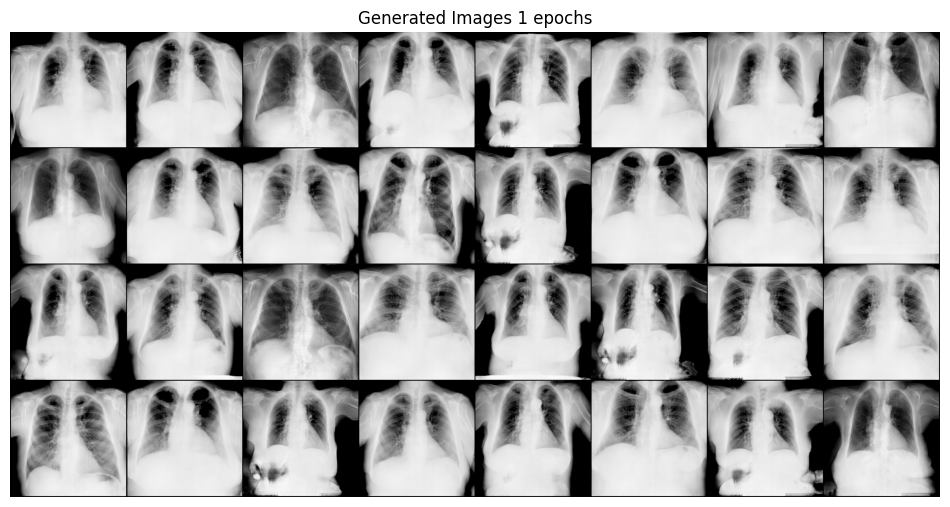

In [30]:
load_model(g, epoch = 30)
show_generated(g)

In [31]:
fid_30 = calculate_fid(g, n_images = n_images, rearrange = True, batch_size = 64)
print('FID 10 epochs score: ', fid_30)

100%|██████████| 504/504 [11:18<00:00,  1.35s/it]


compute FID between two folders
Found 32263 images in the folder /kaggle/working/true


FID true : 100%|██████████| 1009/1009 [02:01<00:00,  8.31it/s]


Found 32263 images in the folder /kaggle/working/dcgan


FID dcgan : 100%|██████████| 1009/1009 [02:02<00:00,  8.27it/s]


FID 10 epochs score:  53.66694552050143


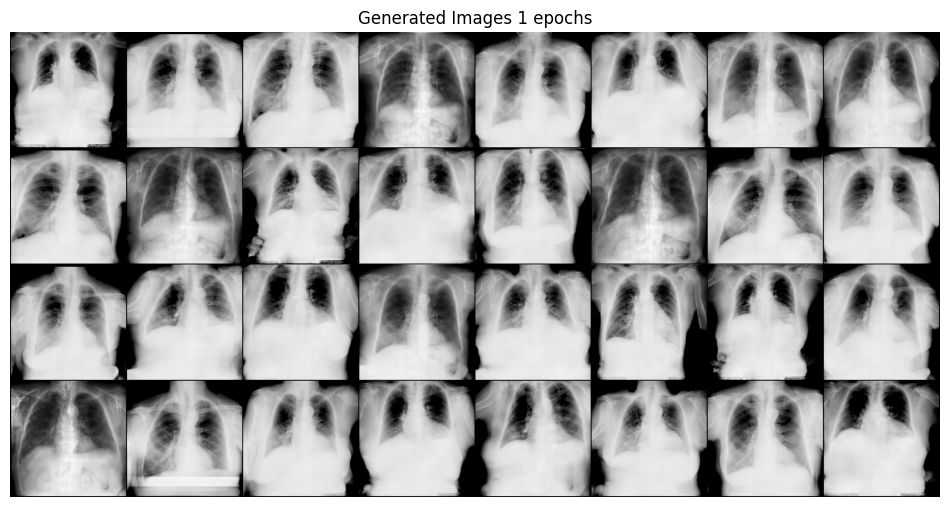

In [32]:
load_model(g, epoch = 40)
show_generated(g)

In [33]:
fid_40 = calculate_fid(g, n_images = n_images, rearrange = True, batch_size = 64)
print('FID 10 epochs score: ', fid_40)

100%|██████████| 504/504 [11:34<00:00,  1.38s/it]


compute FID between two folders
Found 32263 images in the folder /kaggle/working/true


FID true : 100%|██████████| 1009/1009 [02:03<00:00,  8.20it/s]


Found 32263 images in the folder /kaggle/working/dcgan


FID dcgan : 100%|██████████| 1009/1009 [02:04<00:00,  8.12it/s]


FID 10 epochs score:  56.36729191128376


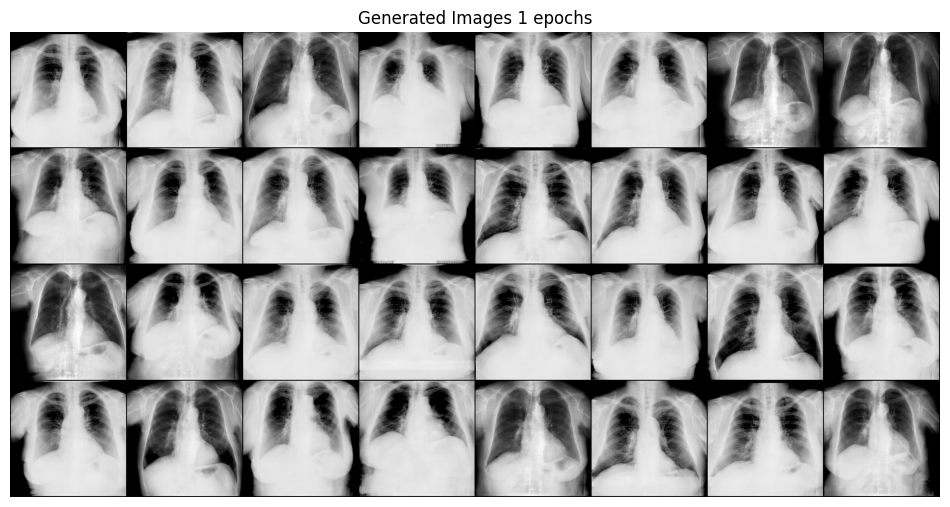

In [34]:
load_model(g, epoch = 50)
show_generated(g)

In [35]:
fid_50 = calculate_fid(g, n_images = n_images, rearrange = True, batch_size = 64)
print('FID 10 epochs score: ', fid_50)

100%|██████████| 504/504 [11:28<00:00,  1.37s/it]


compute FID between two folders
Found 32263 images in the folder /kaggle/working/true


FID true : 100%|██████████| 1009/1009 [02:02<00:00,  8.24it/s]


Found 32263 images in the folder /kaggle/working/dcgan


FID dcgan : 100%|██████████| 1009/1009 [02:03<00:00,  8.18it/s]


FID 10 epochs score:  46.69594427837242


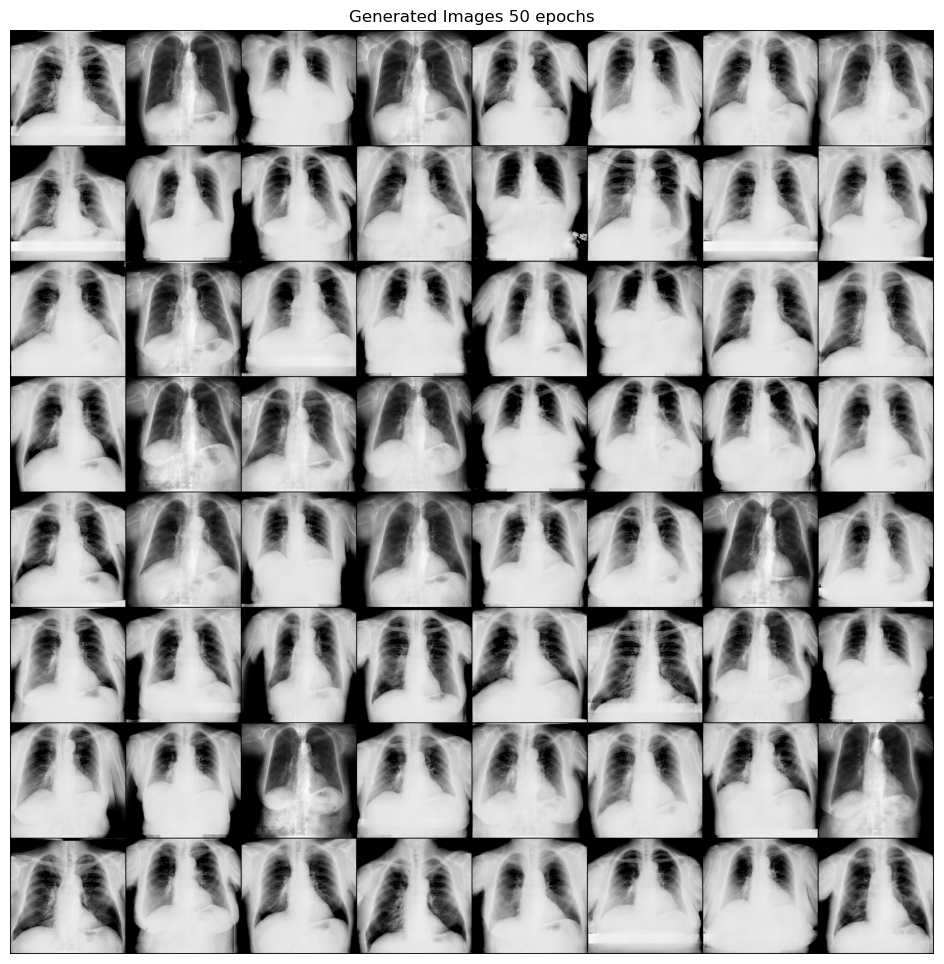

In [17]:
load_model(g, epoch = 50)
show_generated(g, epochs = 50, n_images = 64)

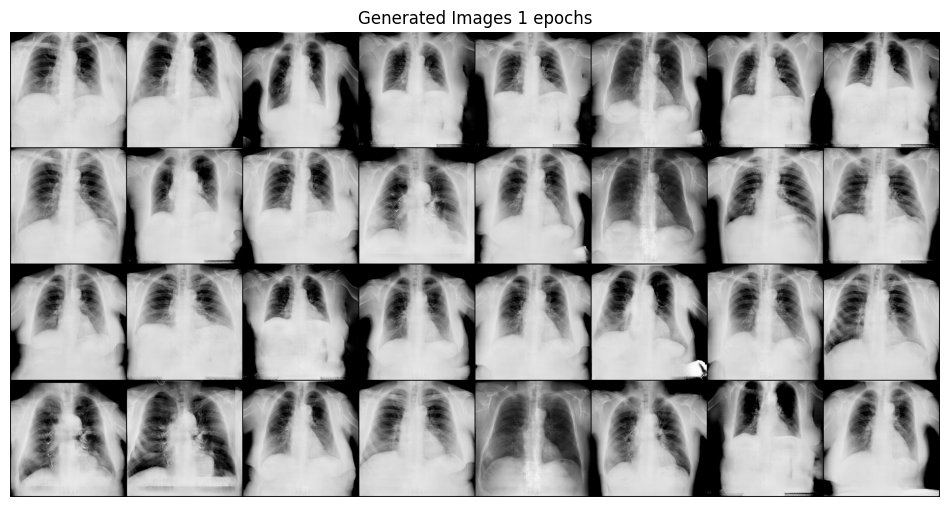

In [36]:
load_model(g, epoch = 60)
show_generated(g)

In [37]:
fid_60 = calculate_fid(g, n_images = n_images, rearrange = True, batch_size = 64)
print('FID 10 epochs score: ', fid_60)

100%|██████████| 504/504 [11:53<00:00,  1.42s/it]


compute FID between two folders
Found 32263 images in the folder /kaggle/working/true


FID true : 100%|██████████| 1009/1009 [02:01<00:00,  8.29it/s]


Found 32263 images in the folder /kaggle/working/dcgan


FID dcgan : 100%|██████████| 1009/1009 [02:03<00:00,  8.19it/s]


FID 10 epochs score:  59.71968766059237


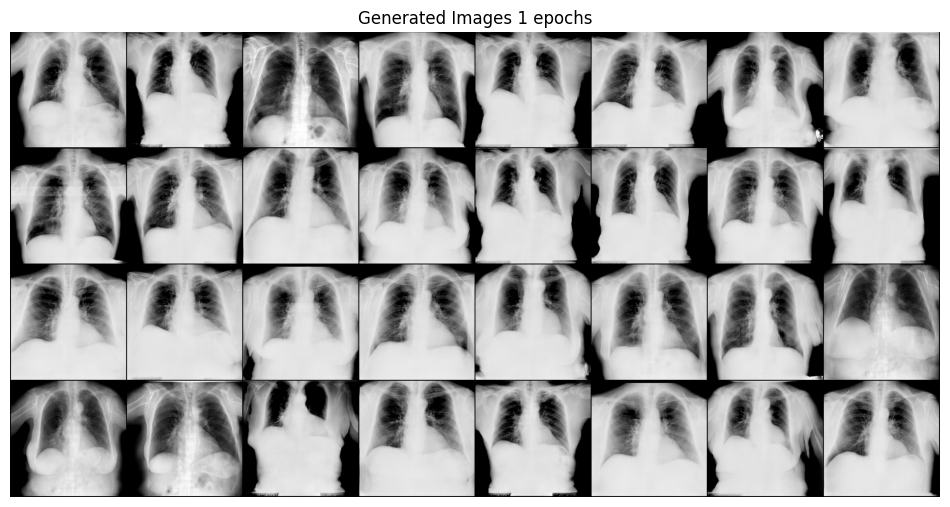

In [38]:
load_model(g, epoch = 70)
show_generated(g)

In [39]:
fid_70 = calculate_fid(g, n_images = n_images, rearrange = True, batch_size = 64)
print('FID 10 epochs score: ', fid_70)

100%|██████████| 504/504 [11:25<00:00,  1.36s/it]


compute FID between two folders
Found 32263 images in the folder /kaggle/working/true


FID true : 100%|██████████| 1009/1009 [02:02<00:00,  8.21it/s]


Found 32263 images in the folder /kaggle/working/dcgan


FID dcgan : 100%|██████████| 1009/1009 [02:03<00:00,  8.20it/s]


FID 10 epochs score:  50.5144699511097
